In [2]:
import os

import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sm

from math import ceil, floor
from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import RANSACRegressor, HuberRegressor, LinearRegression


def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


def simple_regplot(
    x, y, n_std=2, n_pts=100, ax=None, scatter_kws=None, line_kws=None, ci_kws=None
):
    """ Draw a regression line with error interval. """
    ax = plt.gca() if ax is None else ax

    # calculate best-fit line and interval
    x_fit = sm.add_constant(x)
    fit_results = sm.OLS(y, x_fit).fit()

    eval_x = sm.add_constant(np.linspace(np.min(x), np.max(x), n_pts))
    pred = fit_results.get_prediction(eval_x)

    # draw the fit line and error interval
    ci_kws = {} if ci_kws is None else ci_kws
    ax.fill_between(
        eval_x[:, 1],
        pred.predicted_mean - n_std * pred.se_mean,
        pred.predicted_mean + n_std * pred.se_mean,
        alpha=0.5,
        **ci_kws,
    )
    line_kws = {} if line_kws is None else line_kws
    h = ax.plot(eval_x[:, 1], pred.predicted_mean, **line_kws)

    # draw the scatterplot
    scatter_kws = {} if scatter_kws is None else scatter_kws
    ax.scatter(x, y, c=h[0].get_color(), **scatter_kws)

    return fit_results    


def calibrate_branch_trait(field_measurement_df, sensor_measurement_df):

    valid_sensor_measurement_df = sensor_measurement_df.copy()
    for row in field_measurement_df.iterrows():
        section_idx, color, vertical_angle, branch_diameter = row[1][['Section Index', 'Color', 'Crotch Angle/°', 'Diameter/mm']]
        valid_sensor_measurement_df.loc[(valid_sensor_measurement_df['Section_Index']==section_idx)&(valid_sensor_measurement_df['Color']==color), ['Manual_Vertical_Crotch_Angle-Degree']] = vertical_angle
        valid_sensor_measurement_df.loc[(valid_sensor_measurement_df['Section_Index']==section_idx)&(valid_sensor_measurement_df['Color']==color), ['Manual_Branch_Diameter-mm']] = branch_diameter

    return valid_sensor_measurement_df


def calibrate_branch_trait_from_other_excel(sensor_measurement_df, field_measurement_df):

    tmp_df = sensor_measurement_df.loc[~sensor_measurement_df['Label'].isnull(), :]
    valid_sensor_measurement_df = tmp_df.copy()
    valid_sensor_measurement_df['Section_Index'] = valid_sensor_measurement_df['Label'].apply(lambda x: int(x.split('_')[0][-1]))
    valid_sensor_measurement_df['Color'] = valid_sensor_measurement_df['Label'].apply(lambda x: x.split('_')[1])
    calibrated_sensor_measurement_df = calibrate_branch_trait(field_measurement_df, valid_sensor_measurement_df)
    
    return calibrated_sensor_measurement_df  


def plot_best_ransac_fit(x, y, fit_intercept):
    
    x = x.values.reshape(-1, 1)
    y = y.values.reshape(-1, 1)

    # ransac = RANSACRegressor()
    ransac = HuberRegressor(fit_intercept=fit_intercept)
    ransac.fit(x, y)

    line_X = np.arange(x.min(), x.max())[:, np.newaxis]
    line_y_ransac = ransac.predict(line_X)

    return line_X, line_y_ransac, ransac.coef_, ransac.intercept_, ransac.score(x, y)


def plot_linear_fit(x, y, fit_intercept=True):
    
    x = x.values.reshape(-1, 1)
    y = y.values.reshape(-1, 1)

    reg = LinearRegression(fit_intercept=fit_intercept)
    reg.fit(x, y)

    line_X = np.arange(x.min(), x.max())[:, np.newaxis]
    line_y = reg.predict(line_X)

    return line_X, line_y, reg.coef_, reg.intercept_, reg.score(x, y)  


def evaluation(sensor_measurement, x, y, fit_intercept=True):
    estimation = sensor_measurement[x]
    gt = sensor_measurement[y]

    mae = round(mean_absolute_error(gt, estimation), 2)
    mape = round(mean_absolute_percentage_error(gt, estimation), 2)
    rmse = round(mean_squared_error(gt, estimation, squared=False), 2)
    lr_x, lr_y, lr_coef, lr_intercept, lr_score = plot_linear_fit(estimation, gt, fit_intercept=fit_intercept)
    ransac_lr_x, ransac_lr_y, coef, intercept, score = plot_best_ransac_fit(estimation, gt, fit_intercept=fit_intercept)

    return {
        'MAE': mae,
        'MAPE': mape,
        'RMSE': rmse,
        'LR': [lr_x, lr_y, lr_coef, lr_intercept, lr_score],
        'RLR': [ransac_lr_x, ransac_lr_y, coef, intercept, score]
    }


def plot_yx_line(df, x_axis, y_axis, ax, x_interval=5, y_interval=5):
    axs_xticks = df[x_axis].tolist()
    axs_yticks = df[y_axis].tolist()

    axs_xticks_min = floor(min(axs_xticks))
    axs_xticks_max = ceil(max(axs_xticks))
    axs_yticks_min = floor(min(axs_yticks))
    axs_yticks_max = ceil(max(axs_yticks))

    left_end = min(axs_xticks_min, axs_yticks_min)
    right_end = max(axs_xticks_max, axs_yticks_max)
    xtick = list(range(left_end, right_end, x_interval))
    ytick = list(range(left_end, right_end, y_interval))
    
    # set ticks and tick labels
    ax.set_xticks(xtick)
    ax.set_xticklabels(xtick)
    ax.set_yticks(ytick)
    ax.set_yticklabels(ytick)
    
    ref_line_limit = [left_end, right_end]
    x = np.arange(ref_line_limit[0], ref_line_limit[1])
    ax.plot(x, x, color='black', linewidth=3, linestyle='dashed')

In [3]:
import openpyxl

import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
from pathlib import Path

In [4]:
text_in_title_para = {'fontfamily': 'sans-serif', 'fontsize': 12, 'fontweight': 20}
text_in_figure_para = {'fontfamily': 'sans-serif', 'fontsize': 10, 'fontweight': 20, 'horizontalalignment': 'left', 'verticalalignment': 'center'}

In [5]:
data_folder = Path(r'E:\Result\LLC_02022022\Row13')  # LLC_02022022\Row13 KNX_04042023
exp_ids =  [r'Generator2-AdaPoinTr-Skeleton-GAN_FTB55-v2_CDL1_SkelLoss-Supervised-0.01_Finetune',
            r'Generator2-AdaPoinTr-Skeleton-GAN_LTB81-v4_CDL1_SkelLoss-Supervised-0.01_Finetune',
            r'Generator2-AdaPoinTr-Skeleton-GAN_LTB81-v4_CDL1_SkelLoss-Supervised-0.01_Repulsion_CPC-2nd-Stage_Finetune']

E:\Result\KNX_04042023\Generator2-AdaPoinTr-Skeleton-GAN_LTB81_CDL1_Repulsion_SkelLoss-Supervised-1_Finetune\Primary\measurements.csv
E:\Result\KNX_04042023\Generator2-AdaPoinTr-Skeleton-GAN_FTB55_CDL1_Repulsion_SkelLoss-Supervised-1_Finetune\Primary\measurements.csv
E:\Result\KNX_04042023\Generator2-AdaPoinTr-Skeleton-GAN_LTB81-NoTaper_CDL1_Repulsion_SkelLoss-Supervised-1_Finetune\Primary\measurements.csv


d:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


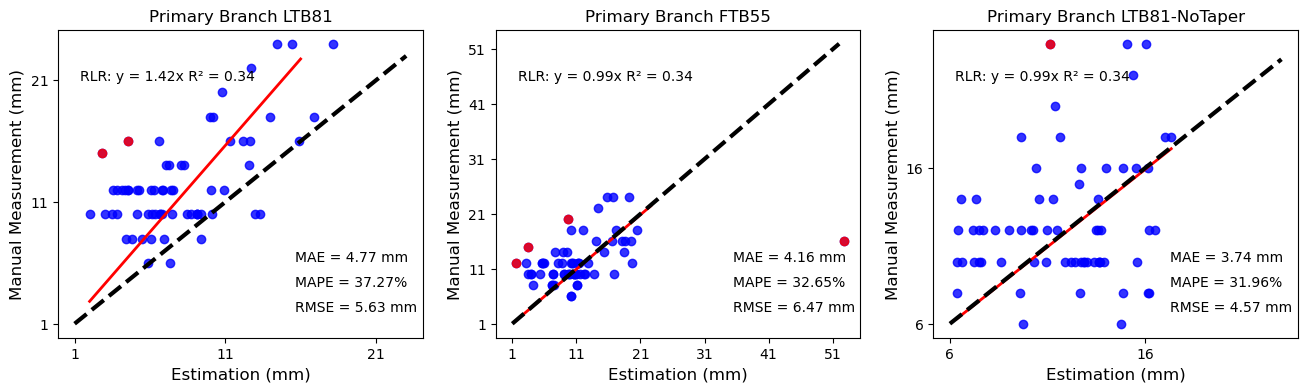

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=len(exp_ids), figsize=(16, 4))

for idx, exp_id in enumerate(exp_ids):

    ax = axes[idx]
    dataset_id = exp_id.split('_')[1]

    tmp_data_folder = data_folder / exp_id / 'Primary'
    excel_files = str(tmp_data_folder / 'measurements.csv')
    print(excel_files)
    df = pd.read_csv(excel_files)
    
    ci = 95
    x_axis = 'Estimated_Diameter' # 'Manual_Vertical_Crotch_Angle-Degree'
    y_axis = 'Diameter (mm)'  # 'Vertical_Croth_Angle-Degree'

    df = df[~df[y_axis].isnull()]

    metrics = evaluation(df, x=x_axis, y=y_axis, fit_intercept=False)
    lr_x, lr_y, lr_coef, lr_intercept, lr_score = metrics['LR']
    ransac_lr_x, ransac_lr_y, rlr_coef, rlr_intercept, rlr_score = metrics['RLR']

    df_mae = abs(df[x_axis] - df[y_axis])
    condition = df_mae > 10
    df_condition_row = df[condition]

    sns.regplot(x=x_axis, y=y_axis, data=df, ci=ci, fit_reg=False, robust=False, scatter_kws={"color": "blue"}, line_kws={"color": "red"}, ax=ax)
    sns.regplot(x=x_axis, y=y_axis, data=df_condition_row, ci=ci, fit_reg=False, robust=False, scatter_kws={"color": "red"}, line_kws={"color": "red"}, ax=ax)

    # ax.plot(lr_x, lr_y, color="green", linewidth=2, label="Linear regressor")
    ind = ransac_lr_y <= 23
    ax.plot(ransac_lr_x[ind], ransac_lr_y[ind], color="red", linewidth=2, label="Huber regressor")
    ax.text(0.06, 0.85, f'RLR: y = {rlr_coef[0]:.2f}x R\u00b2 = {0.34:.2f}', **text_in_figure_para, transform=ax.transAxes)
    # ax.text(0.06, 0.82, f'LR:   y = {lr_coef[0][0]:.2f}x R\u00b2 = {lr_score:.2f}', **text_in_figure_para, transform=ax.transAxes)
    ax.text(0.65, 0.26, f"MAE = {metrics['MAE']} mm", **text_in_figure_para, transform=ax.transAxes)
    ax.text(0.65, 0.18, f"MAPE = {metrics['MAPE']}%", **text_in_figure_para, transform=ax.transAxes)
    ax.text(0.65, 0.1, f"RMSE = {metrics['RMSE']} mm", **text_in_figure_para, transform=ax.transAxes)
    ax.set_title(f'Primary Branch {dataset_id}', **text_in_title_para)
    ax.set_xlabel('Estimation (mm)', **text_in_title_para)
    ax.set_ylabel('Manual Measurement (mm)', **text_in_title_para)

    # plot 1:1 line
    plot_yx_line(df, x_axis, y_axis, ax, x_interval=10, y_interval=10)

fig_path = os.path.join(data_folder, 'comparison_G2.png')
plt.savefig(fig_path, dpi=300)

E:\Result\LLC_02022022\Row13\Generator2-AdaPoinTr-Skeleton-GAN_FTB55-v2_CDL1_SkelLoss-Supervised-0.01_Finetune\All\measurements.csv
E:\Result\LLC_02022022\Row13\Generator2-AdaPoinTr-Skeleton-GAN_FTB55-v2_CDL1_SkelLoss-Supervised-0.01_Finetune\Primary\measurements.csv


d:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


E:\Result\LLC_02022022\Row13\Generator2-AdaPoinTr-Skeleton-GAN_LTB81-v4_CDL1_SkelLoss-Supervised-0.01_Finetune\All\measurements.csv
E:\Result\LLC_02022022\Row13\Generator2-AdaPoinTr-Skeleton-GAN_LTB81-v4_CDL1_SkelLoss-Supervised-0.01_Finetune\Primary\measurements.csv
E:\Result\LLC_02022022\Row13\Generator2-AdaPoinTr-Skeleton-GAN_LTB81-v4_CDL1_SkelLoss-Supervised-0.01_Repulsion_CPC-2nd-Stage_Finetune\All\measurements.csv
E:\Result\LLC_02022022\Row13\Generator2-AdaPoinTr-Skeleton-GAN_LTB81-v4_CDL1_SkelLoss-Supervised-0.01_Repulsion_CPC-2nd-Stage_Finetune\Primary\measurements.csv


d:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


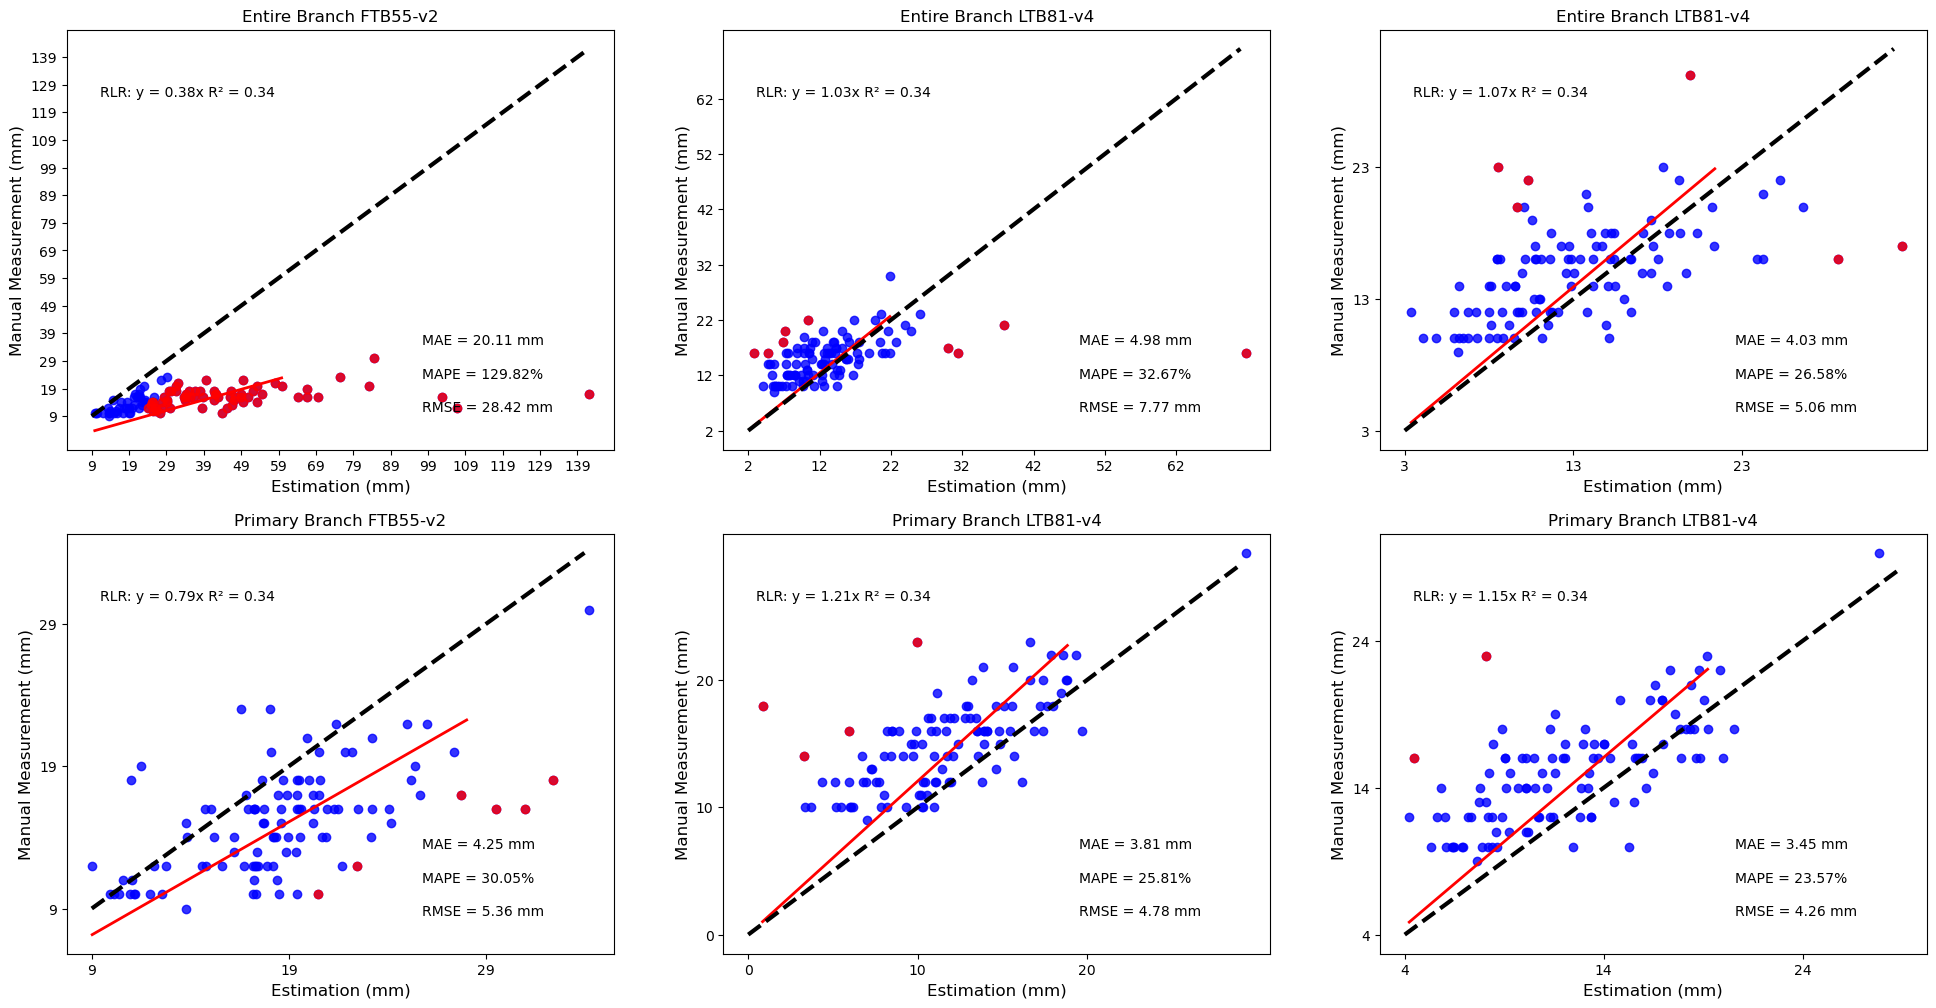

In [6]:
fig, axes = plt.subplots(nrows=2, ncols=len(exp_ids), figsize=(8*len(exp_ids), 4*len(exp_ids)))

for idx, exp_id in enumerate(exp_ids):

    ax = axes[0][idx]
    dataset_id = exp_id.split('_')[1]
    tmp_data_folder = data_folder / exp_id / 'All'
    excel_files = str(tmp_data_folder / 'measurements.csv')
    print(excel_files)
    df = pd.read_csv(excel_files)

    ci = 95
    x_axis = 'Estimated_Diameter' # 'Manual_Vertical_Crotch_Angle-Degree'
    y_axis = 'Diameter (mm)'  # 'Vertical_Croth_Angle-Degree'
    metrics = evaluation(df, x=x_axis, y=y_axis, fit_intercept=False)
    lr_x, lr_y, lr_coef, lr_intercept, lr_score = metrics['LR']
    ransac_lr_x, ransac_lr_y, rlr_coef, rlr_intercept, rlr_score = metrics['RLR']

    df_mae = abs(df[x_axis] - df[y_axis])
    condition = df_mae > 10
    df_condition_row = df[condition]

    sns.regplot(x=x_axis, y=y_axis, data=df, ci=ci, fit_reg=False, robust=False, scatter_kws={"color": "blue"}, line_kws={"color": "red"}, ax=ax)
    sns.regplot(x=x_axis, y=y_axis, data=df_condition_row, ci=ci, fit_reg=False, robust=False, scatter_kws={"color": "red"}, line_kws={"color": "red"}, ax=ax)

    # ax.plot(lr_x, lr_y, color="green", linewidth=2, label="Linear regressor")
    ind = ransac_lr_y <= 23
    ax.plot(ransac_lr_x[ind], ransac_lr_y[ind], color="red", linewidth=2, label="Huber regressor")
    ax.text(0.06, 0.85, f'RLR: y = {rlr_coef[0]:.2f}x R\u00b2 = {0.34:.2f}', **text_in_figure_para, transform=ax.transAxes)
    # ax.text(0.06, 0.82, f'LR:   y = {lr_coef[0][0]:.2f}x R\u00b2 = {lr_score:.2f}', **text_in_figure_para, transform=ax.transAxes)
    ax.text(0.65, 0.26, f"MAE = {metrics['MAE']} mm", **text_in_figure_para, transform=ax.transAxes)
    ax.text(0.65, 0.18, f"MAPE = {metrics['MAPE']}%", **text_in_figure_para, transform=ax.transAxes)
    ax.text(0.65, 0.1, f"RMSE = {metrics['RMSE']} mm", **text_in_figure_para, transform=ax.transAxes)
    ax.set_title(f'Entire Branch {dataset_id}', **text_in_title_para)
    ax.set_xlabel('Estimation (mm)', **text_in_title_para)
    ax.set_ylabel('Manual Measurement (mm)', **text_in_title_para)

    # plot 1:1 line
    plot_yx_line(df, x_axis, y_axis, ax, x_interval=10, y_interval=10)

    ### ============== ###
    ### Primary Branch
    ### ============== ###
    ax = axes[1][idx]

    tmp_data_folder = data_folder / exp_id / 'Primary'
    excel_files = str(tmp_data_folder / 'measurements.csv')
    print(excel_files)
    df = pd.read_csv(excel_files)

    ci = 95
    x_axis = 'Estimated_Diameter' # 'Manual_Vertical_Crotch_Angle-Degree'
    y_axis = 'Diameter (mm)'  # 'Vertical_Croth_Angle-Degree'
    metrics = evaluation(df, x=x_axis, y=y_axis, fit_intercept=False)
    lr_x, lr_y, lr_coef, lr_intercept, lr_score = metrics['LR']
    ransac_lr_x, ransac_lr_y, rlr_coef, rlr_intercept, rlr_score = metrics['RLR']

    df_mae = abs(df[x_axis] - df[y_axis])
    condition = df_mae > 10
    df_condition_row = df[condition]

    sns.regplot(x=x_axis, y=y_axis, data=df, ci=ci, fit_reg=False, robust=False, scatter_kws={"color": "blue"}, line_kws={"color": "red"}, ax=ax)
    sns.regplot(x=x_axis, y=y_axis, data=df_condition_row, ci=ci, fit_reg=False, robust=False, scatter_kws={"color": "red"}, line_kws={"color": "red"}, ax=ax)

    # ax.plot(lr_x, lr_y, color="green", linewidth=2, label="Linear regressor")
    ind = ransac_lr_y <= 23
    ax.plot(ransac_lr_x[ind], ransac_lr_y[ind], color="red", linewidth=2, label="Huber regressor")
    ax.text(0.06, 0.85, f'RLR: y = {rlr_coef[0]:.2f}x R\u00b2 = {0.34:.2f}', **text_in_figure_para, transform=ax.transAxes)
    # ax.text(0.06, 0.82, f'LR:   y = {lr_coef[0][0]:.2f}x R\u00b2 = {lr_score:.2f}', **text_in_figure_para, transform=ax.transAxes)
    ax.text(0.65, 0.26, f"MAE = {metrics['MAE']} mm", **text_in_figure_para, transform=ax.transAxes)
    ax.text(0.65, 0.18, f"MAPE = {metrics['MAPE']}%", **text_in_figure_para, transform=ax.transAxes)
    ax.text(0.65, 0.1, f"RMSE = {metrics['RMSE']} mm", **text_in_figure_para, transform=ax.transAxes)
    ax.set_title(f'Primary Branch {dataset_id}', **text_in_title_para)
    ax.set_xlabel('Estimation (mm)', **text_in_title_para)
    ax.set_ylabel('Manual Measurement (mm)', **text_in_title_para)

    # plot 1:1 line
    plot_yx_line(df, x_axis, y_axis, ax, x_interval=10, y_interval=10)

fig_path = os.path.join(data_folder, 'comparison_G2.png')
plt.savefig(fig_path, dpi=300)